In [10]:
import pandas
import math
import parse
import process
%load_ext Cython

#%%cython
########################################################
evidence_file = 'data/evidence.txt'
filtered_evidence_file = 'data/evidence_filtered.txt'
protein_groups_file = 'data/proteinGroups.txt'
phospho_peptide_file = 'data/Phospho (STY)Sites.txt'
our_group_name = 'PYND'
other_group_names = ['APUBSCRAWL', 'ONION', 'ET0H', 'SHMOO', 'WHANGEE'] # Case doesn't matter

experiment_ext_names = ['Ub', 'UbP', 'WCL', 'WCLP']


########################################################

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [12]:

# Now apply the filter to evidence.txt to get evidence_filtered.tsv
# This should keep only the lines for our group
parse.filter_tsv(evidence_file, filtered_evidence_file, 'Experiment', '^[Pp][Yy][Nn][Dd]')
print('Done.')

Done.


In [14]:
evidence = parse.parse_evidence(filtered_evidence_file)

protein_groups = parse.parse_protein_groups(protein_groups_file)
protein_groups = parse.remove_cols(protein_groups, other_group_names)

phospho = parse.parse_phosphosites(phospho_peptide_file)
phospho = parse.filter_other_groups(phospho)

Protein IDs                             object
Majority protein IDs                    object
Peptide counts (all)                    object
Peptide counts (razor+unique)           object
Peptide counts (unique)                 object
Fasta headers                           object
Number of proteins                       int64
Peptides                                 int64
Razor + unique peptides                  int64
Unique peptides                          int64
Peptides Apubscrawl_Cerulenin_Ub         int64
Peptides Apubscrawl_Cerulenin_UbP        int64
Peptides Apubscrawl_Cerulenin_WCL        int64
Peptides Apubscrawl_Cerulenin_WCLP       int64
Peptides Apubscrawl_Swe1KO_Ub            int64
Peptides Apubscrawl_Swe1KO_UbP           int64
Peptides Apubscrawl_Swe1KO_WCL           int64
Peptides Apubscrawl_Swe1KO_WCLP          int64
Peptides Control_Ub                      int64
Peptides Control_UbP                     int64
Peptides Control_WCL                     int64
Peptides Cont

/Users/student/anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (421,422) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


AttributeError: 'module' object has no attribute 'remove_cols'

In [101]:
def calc_epsilon(protein_groups):
    mins=[]
    for col in protein_groups.columns:
        for exp_ext in experiment_ext_names:
            if 'Intensity' in col and col.endswith(exp_ext):
                miny=float("inf")
                for x in protein_groups[col]:
                    x = float(x)
                    if x < miny and x != 0.0:
                        miny = x
                if miny != 0.0:
                    mins.append(miny)
    return min(mins)
epsilon = calc_epsilon(protein_groups)
epsilon

6193.8

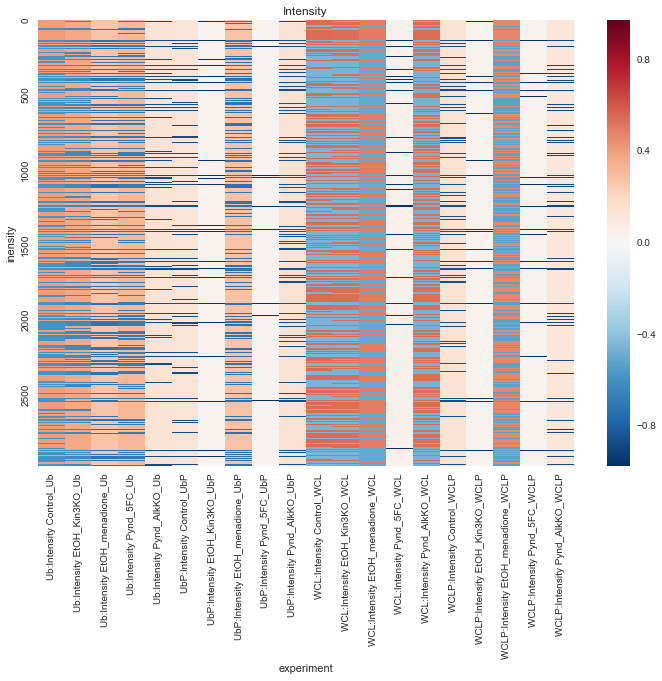

In [87]:
# What's the distribution of intensities?
def get_intensity_dists(protein_groups):
    dists={}
    for col in protein_groups.columns:
        for exp_ext in experiment_ext_names:
            if 'Intensity' in col and col.endswith(exp_ext):
                t = col.split('_')[-1] # to get sorting of keys right
                dists[t + ":" + col] = protein_groups[col].apply(lambda x: math.log(x, 2) if x > 0 else epsilon)
    return dists

dists = get_intensity_dists(protein_groups)

import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(rc={"figure.figsize": (12, 8)})
intensities = pandas.DataFrame(dists)
intensities = (intensities - intensities.mean()) / (intensities.max() - intensities.min())
sns.heatmap(intensities, yticklabels=500)
sns.axlabel("experiment", "inensity")
plt.title("Intensity")



In [1]:
from scipy import stats, integrate
def plot_for_exp(dists, exp):
    for key, value in dists.items():
        lst = value != 0
        bandwidth = 2 * lst.std() * lst.size ** (-1 / 5.)
        if key.startswith(exp + ':') or 'Control' in exp:
            sns.kdeplot(lst, bw=bandwidth, label=key)
            #sns.distplot(lst, bins=200, kde=False, rug=False);
    sns.axlabel("intensity", "frequency")
    plt.title("Intensities for %s experiment" % exp)
    plt.show()
plot_for_exp(dists, 'WCL')
plot_for_exp(dists, 'WCLP')
plot_for_exp(dists, 'Ub')
plot_for_exp(dists, 'UbP')

NameError: name 'dists' is not defined